<a href="https://colab.research.google.com/github/alexlopespereira/mba_enap/blob/main/CD/Notebooks/Aula1_GraficosStoryTelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aula 1 - Gráficos com Seaborn e Story Telling


### Vamos estudar algumas (poucas) opções de configuração dos gráficos do Seaborn.

*   Remover Clutter
*   Adicionar Label aos eixos
*   Remover as bordas do gráfico
*   Ajustar a cor de fundo
*   Definir o intervalo numérico dos eixos
*   Definir os ticks dos eixos

Investiremos mais tempo adiquirindo habilidades de Storytelling no Data Studio e no Observable. Por que?


### Importar as bibliotecas

In [1]:
import numpy as np # Importar o numpy
import pandas as pd


### O dataset deste estudo de caso: [Aquecimento Global](https://data.giss.nasa.gov/gistemp/graphs_v3/)

In [109]:
# 1) O dataset que está em "https://data.giss.nasa.gov/gistemp/graphs_v3/graph_data/GISTEMP_Seasonal_Cycle_since_1880/graph.csv" (o dataset foi retirado do gráfico)
# Tambem disponibilizei aqui https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/aquecimento_global/graph.csv

df = pd.read_csv("https://github.com/alexlopespereira/mba_enap/raw/refs/heads/main/data/originais/aquecimento_global/graph.csv", skiprows=1, dtype={"Year":str})


In [110]:
# 2) Fazer transformações necessárias nas colunas. Coloque o ano numa coluna e o mês em outra. O mês está num formato numérico que não coincide com nosso calendário.
df[['ano', 'mes']] = df['Year'].str.split('.', expand=True)
df['ano'] = df['ano'].astype(np.int64)
map_mes_abreviado = {'04': 'jan', '13': 'feb', '21': 'mar', '29': 'apr', '38': 'may', '46': 'jun', '54': 'jul', '63': 'aug', '71': 'sep', '79': 'oct', '88': 'nov', '96': 'dec'}
#map_mes = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

map_mes_num = {'04': 1, '13': 2, '21': 3, '29': 4, '38': 5, '46': 6, '54': 7, '63': 8, '71': 9, '79': 10, '88': 11, '96': 12}
df['mes_num'] = df['mes'].map(map_mes_num)

df['mes'] = df['mes'].map(map_mes_abreviado)
df['date'] = df[['ano', 'mes_num']].apply(lambda x: f"{x['ano']}-{x['mes_num']}-01", axis=1)
df['mes'] = pd.Categorical(df['mes'], ordered=True, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
# del df['Year']
df.head()


,Year,Anomaly,ano,mes,mes_num,date
0,1880.04,-2.70,1880,jan,1,1880-1-01
1,1880.13,-2.33,1880,feb,2,1880-2-01
2,1880.21,-1.58,1880,mar,3,1880-3-01
3,1880.29,-0.67,1880,apr,4,1880-4-01
4,1880.38,0.35,1880,may,5,1880-5-01


### Sobre este assunto, existe uma bonita visualização de dados usando uma técnica chamada scrolltelling [aqui](https://www.bloomberg.com/graphics/2015-whats-warming-the-world/)

### Metadados para entender o dataset encontram-se disponíveis [aqui](https://data.giss.nasa.gov/gistemp/). O trecho de texto abaixo foi retirado desse link:
##### *The following are plain-text files in tabular format of temperature anomalies, i.e. deviations from the corresponding 1951-1980 means.*
*   *Global-mean monthly, seasonal, and annual means, 1880-present, updated through most recent month*

## Plotando um gráfico parecido com o plotnine
### Prompt: usando o plotnine, plote um grafico de linha com o ano no eixo x e a media da coluna Anomaly no eixo y. Use uma figura do tamanho 8x4 polegadas.


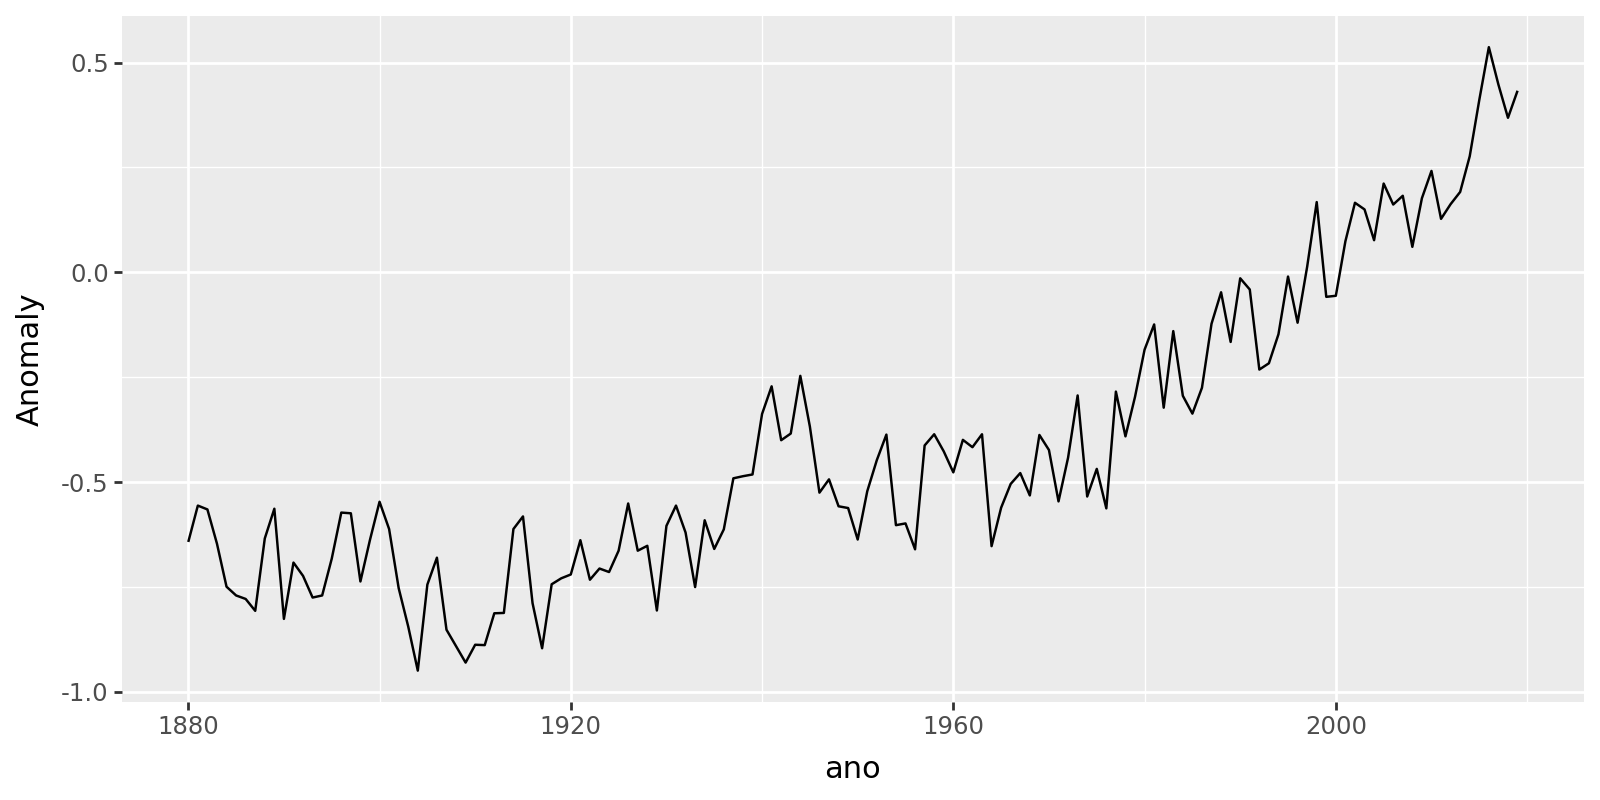

In [79]:
from plotnine import ggplot, aes, geom_line, theme
import numpy as np

(ggplot(df, aes(x='ano', y='Anomaly'))
 + geom_line(stat="summary", fun_y=np.mean)
 + theme(figure_size=(8, 4))
)

### Plotando o intervalo de confiança de 95%

### Prompt que fiz na perplexity:

nesse grafico: """\(ggplot(df, aes(x='ano', y='Anomaly'))
\+ geom_line(stat="summary", fun_y=np.mean)
\+ theme(aspect_ratio=1/2) # Adjust aspect ratio (height/width)
\)""" adicione um intervalo de confiança em torno da média representada pela linha do grafico

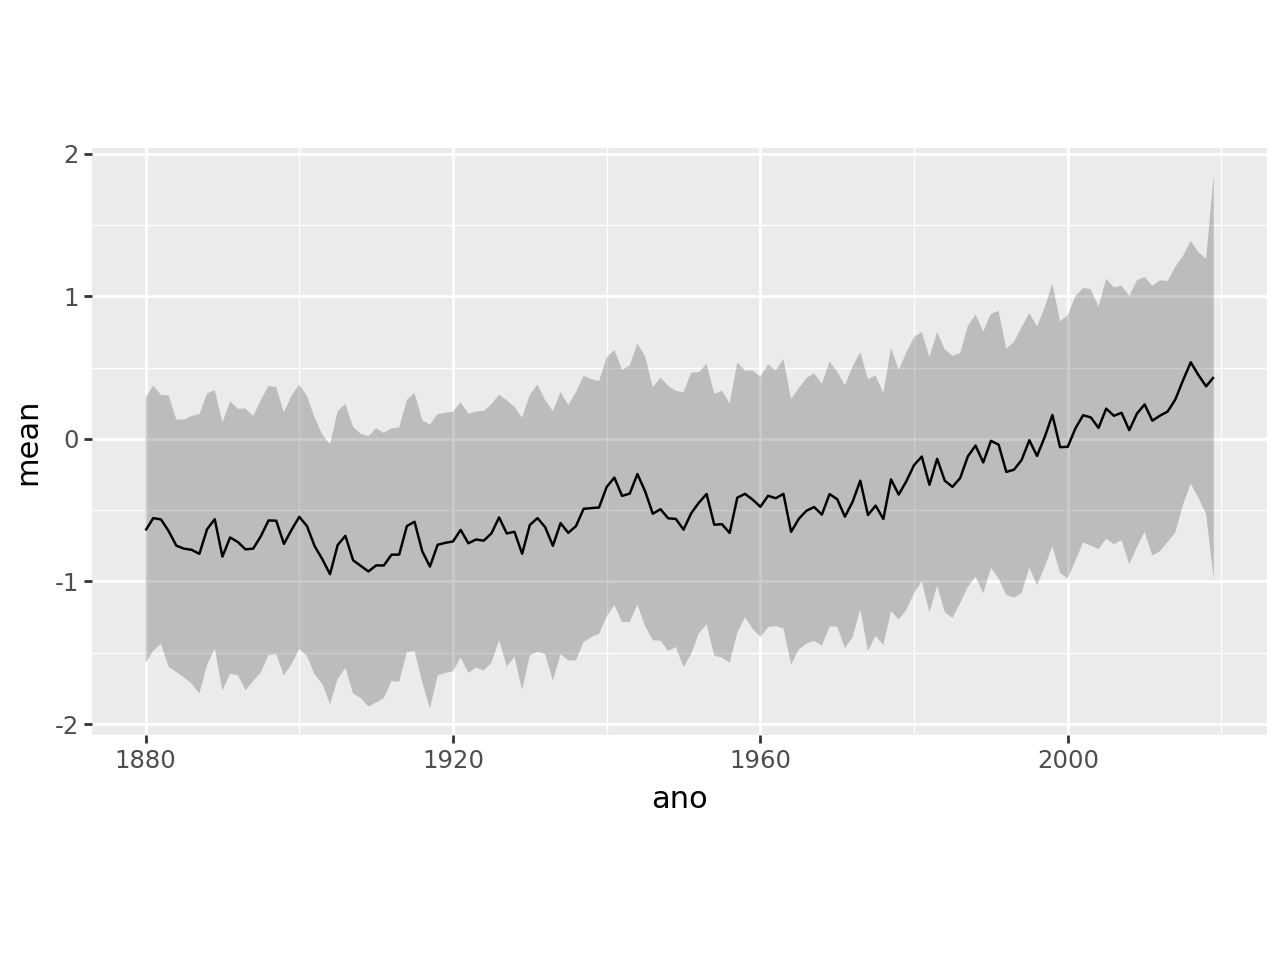

In [80]:
import numpy as np
import pandas as pd
from scipy import stats
from plotnine import ggplot, aes, geom_line, geom_ribbon, theme

# 1) Resumir por ano: média, desvio-padrão, n e IC95%
g = df.groupby('ano')['Anomaly']
summary = g.agg(mean='mean', sd='std', n='size').reset_index()
summary['se'] = summary['sd'] / np.sqrt(summary['n'])
# t crítico para 95% (bilateral) com n-1 graus de liberdade
summary['tcrit'] = stats.t.ppf(1-0.025, summary['n']-1)
summary['ci'] = summary['tcrit'] * summary['se']
summary['ymin'] = summary['mean'] - summary['ci']
summary['ymax'] = summary['mean'] + summary['ci']

# 2) Plot: faixa de IC + linha da média
p = (
    ggplot(summary, aes(x='ano', y='mean'))
    + geom_ribbon(aes(ymin='ymin', ymax='ymax'), alpha=0.25)  # IC95%
    + geom_line()                                             # média
    + theme(aspect_ratio=1/2)
)
p


## Vamos tentar reproduzir o gráfico a seguir.
### Disponível [aqui](https://data.giss.nasa.gov/gistemp/graphs_v3/).


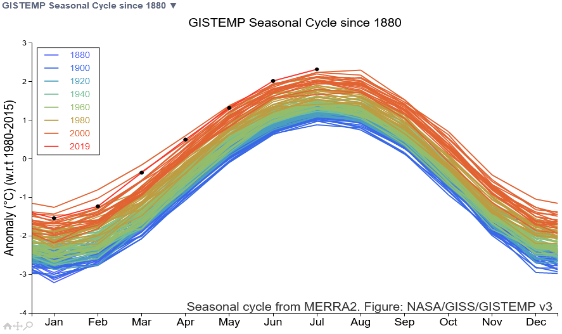

### Prompt: considerando o dataframe df, usando o plotnine, plote um grafico de linhas, com multiplas series. Onde cada série é representada por um ano. No eixo y plote o valor da coluna Anomaly, e no eixo x os meses do ano. Use o colormap coolwarm.

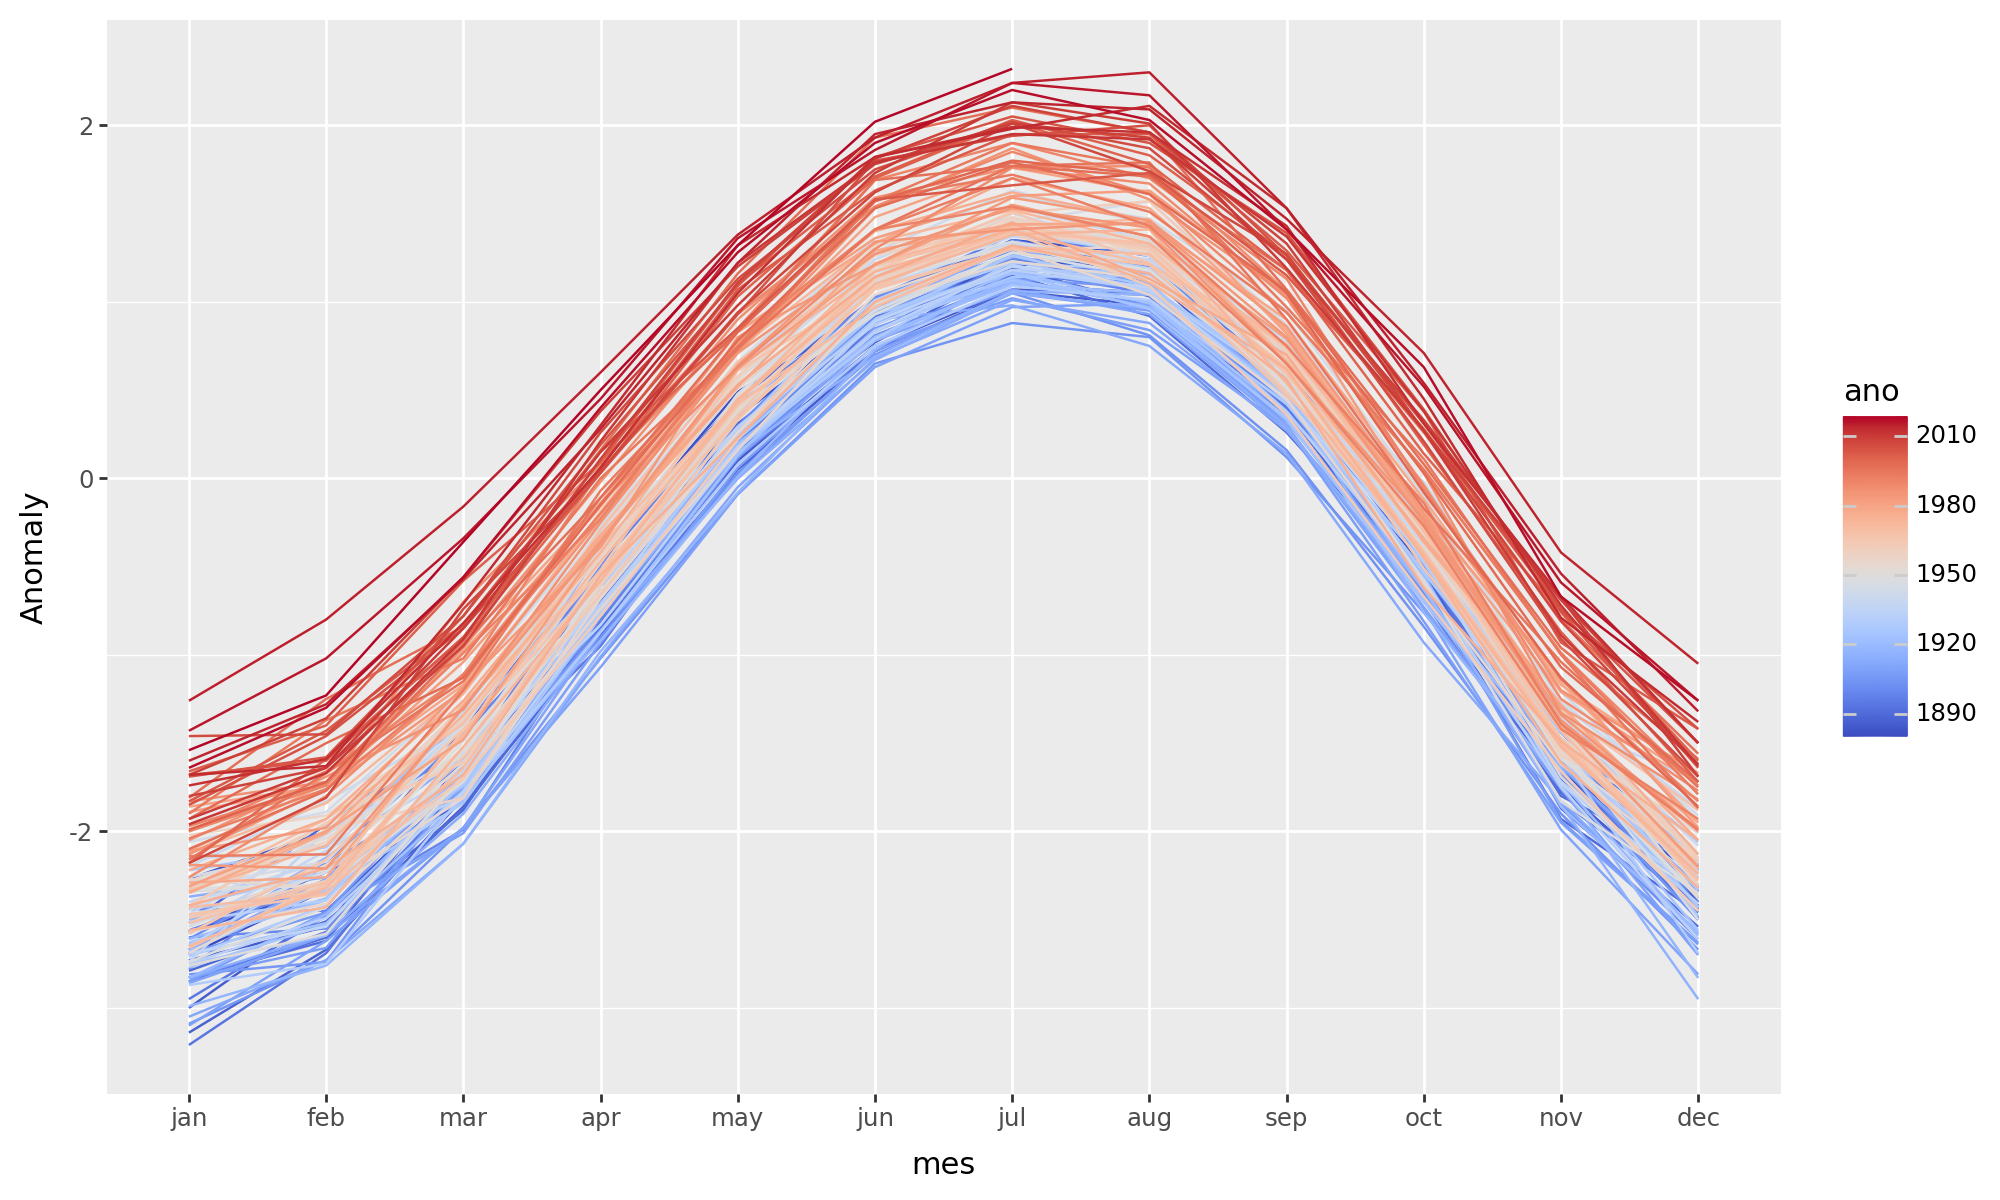

In [91]:
from plotnine import ggplot, aes, geom_line, theme, scale_color_cmap

(ggplot(df, aes(x='mes', y='Anomaly', group='ano', color='ano'))
 + geom_line()
 + scale_color_cmap("coolwarm")
 + theme(figure_size=(10, 6))
)

## Como ajustar a cor de uma categoria, caso você tenha uma mensagem para a sua audiência sobre esta categoria

In [ ]:
{i: "r" if i in ['dez','jan'] else "gray" for i in df['mes'].unique()}

{'abr': 'gray',
 'ago': 'gray',
 'dez': 'r',
 'fev': 'gray',
 'jan': 'r',
 'jul': 'gray',
 'jun': 'gray',
 'mai': 'gray',
 'mar': 'gray',
 'nov': 'gray',
 'out': 'gray',
 'set': 'gray'}

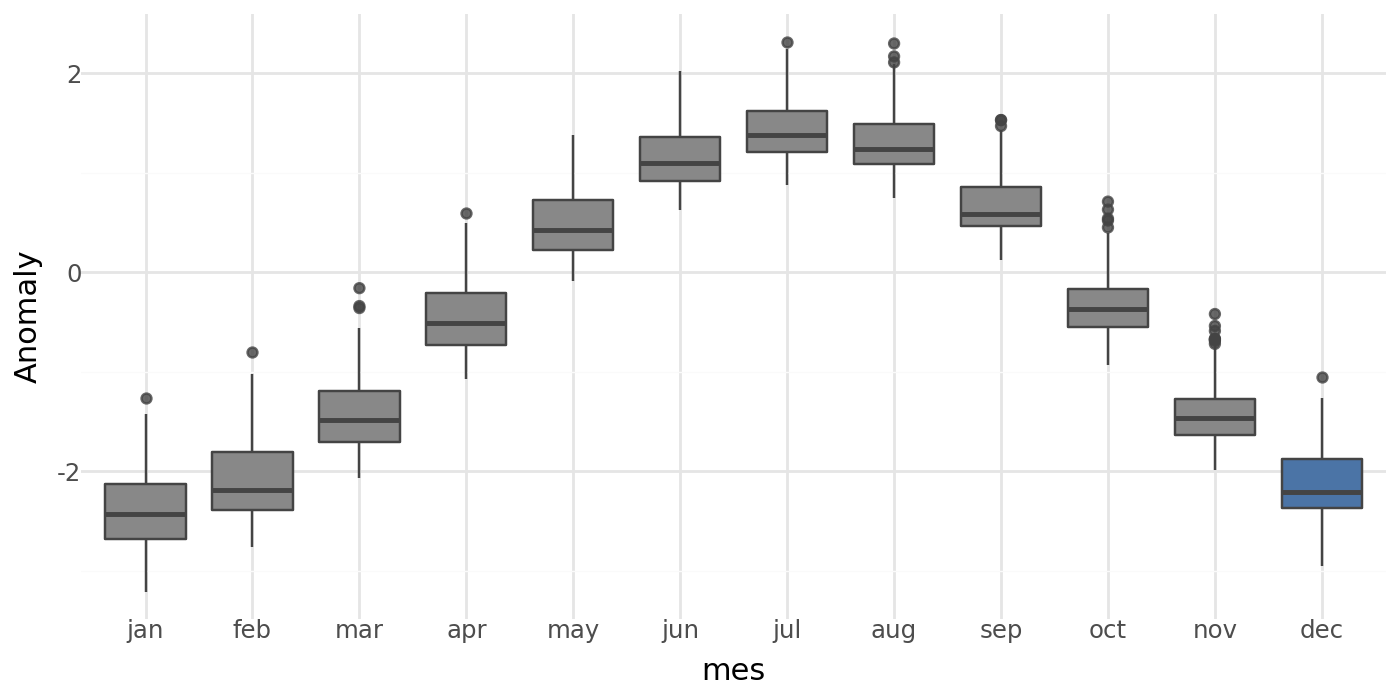

In [112]:
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, theme_minimal, scale_x_discrete, theme, scale_fill_manual

# Supondo que seu DataFrame se chama df e tem colunas: 'mes' (str ou int) e 'Anomaly' (numérico)
# Se for número, converta para rótulos abreviados em português:
ordem_meses = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
df['mes'] = pd.Categorical(df['mes'], categories=ordem_meses, ordered=True)
df['destaque'] = df['mes'].apply(lambda m: 'dec' if m=='dec' else 'outro')

# Plot
p = (
    ggplot(df, aes(x='mes', y='Anomaly', fill='destaque'))
    + geom_boxplot(color="#444444", outlier_alpha=0.8)
    + scale_fill_manual(values={'dec':'#4B74A6', 'outro':'#888888'})
    + theme_minimal()
    + theme(figure_size=(7,3.5))
    + guides(fill=False)  # Remove legenda do destaque se quiser
)
p

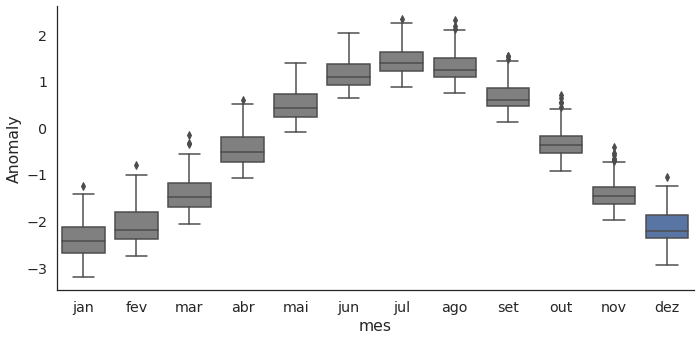

In [ ]:
# Aumentar o tamanho da fonte
# Como alterar o tamanho da fonte
sns.set(font_scale=1.3, style="white")

my_pal = {i: "b" if i in ['dez'] else "gray" for i in df['mes'].unique()}

g = sns.catplot(y="Anomaly", data=df, kind="box", x="mes", aspect=2, palette=my_pal)

## Vamos tentar reproduzir este [gráfico](http://berkeleyearth.org/dv/temperature-change-vs-carbon-dioxide-concentration/) que mostra a correlação entre o aumento de emissão de CO2 e o aumento médio da temperatura global.
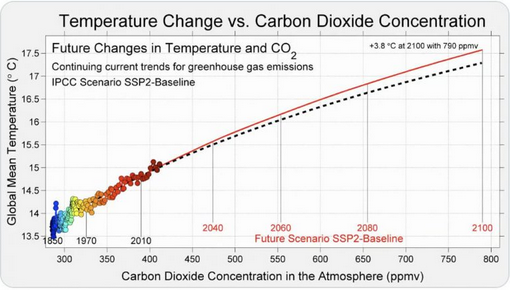

In [ ]:
# Fonte: https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions
# Vamos usar a variável da coluna co2
dfco2_orig = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")
dfco2_orig

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,0.00,0.015,0.00,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,NaN,475.00,0.070,NaN,0.011,NaN,0.00,0.099,0.00,0.009,NaN,NaN,0.021,NaN,NaN,NaN,0.063,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.036,NaN,NaN,0.063,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,NaN,8.70,0.007,NaN,0.012,NaN,0.00,0.191,0.00,0.010,NaN,NaN,0.026,NaN,NaN,NaN,0.066,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.061,NaN,NaN,0.129,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,NaN,0.00,0.000,NaN,0.012,NaN,0.00,0.282,0.00,0.009,NaN,NaN,0.032,NaN,NaN,NaN,0.060,NaN,NaN,0.004,NaN,NaN,0.008,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.093,NaN,NaN,0.189,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,NaN,16.00,0.015,NaN,0.013,NaN,0.00,0.388,0.00,0.010,NaN,NaN,0.038,NaN,NaN,NaN,0.068,NaN,NaN,0.005,NaN,NaN,0.008,NaN,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.131,NaN,NaN,0.257,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25199,ZWE,Zimbabwe,2016,10.738,12.153,-12.17,-1.488,1.415,0.765,0.866,0.03,736.467,0.05,0.512,0.580,0.226,6.959,0.639,NaN,NaN,3.139,NaN,0.046,0.496,NaN,NaN,0.224,NaN,13.18,0.04,0.05,NaN,NaN,0.03,NaN,18.188,585.104,NaN,NaN,133.175,NaN,0.05,0.08,NaN,NaN,0.02,NaN,65.98,4.703,11.92,0.85,6.55,0.467,14030338.0,2.096179e+10,47.5,3385.574,1.889
25200,ZWE,Zimbabwe,2017,9.582,11.248,-10.77,-1.156,1.666,0.673,0.790,0.03,746.049,0.05,0.437,0.512,NaN,5.665,0.678,NaN,NaN,3.239,NaN,0.048,0.398,NaN,NaN,0.228,NaN,17.39,0.05,0.04,NaN,NaN,0.03,NaN,18.866,590.768,NaN,NaN,136.414,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14236599.0,2.194784e+10,NaN,NaN,NaN
25201,ZWE,Zimbabwe,2018,11.854,13.163,23.72,2.273,1.308,0.821,0.912,0.03,757.903,0.05,0.522,0.580,NaN,7.101,0.697,NaN,NaN,4.056,NaN,0.048,0.492,NaN,NaN,0.281,NaN,11.04,0.04,0.05,NaN,NaN,0.03,NaN,19.564,597.869,NaN,NaN,140.470,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14438812.0,2.271535e+10,NaN,NaN,NaN
25202,ZWE,Zimbabwe,2019,10.949,12.422,-7.64,-0.905,1.473,0.748,0.848,0.03,768.852,0.05,NaN,NaN,NaN,6.020,0.697,NaN,NaN,4.232,NaN,0.048,0.411,NaN,NaN,0.289,NaN,13.45,0.04,0.04,NaN,NaN,0.03,NaN,20.261,603.889,NaN,NaN,144.702,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14645473.0,NaN,NaN,

In [ ]:
# Vamos agregar pelo ano e somar a emissão de co2
# Transforme a serie agregada num dataframe e converta indice para coluna
dfco2g = dfco2_orig.groupby('year')['co2'].sum().to_frame().reset_index()
dfco2g.head()

,year,co2
0,1750,46.755
1,1751,46.755
2,1752,46.770
3,1753,46.770
4,1754,46.790


In [ ]:
# Faça o merge dos dois dataframes: de temperatura e de CO2
dfmerge = df.merge(dfco2g, left_on='ano', right_on='year')
dfmerge['co2'] = dfmerge['co2'].round(1)
dfmerge.head()

,Anomaly,ano,mes,mes_num,date,year,co2
0,-2.70,1880,jan,1,1880-1-01,1880,3852.3
1,-2.33,1880,feb,2,1880-2-01,1880,3852.3
2,-1.58,1880,mar,3,1880-3-01,1880,3852.3
3,-0.67,1880,apr,4,1880-4-01,1880,3852.3
4,0.35,1880,may,5,1880-5-01,1880,3852.3


In [ ]:
dfmerge.to_json('./temperature_anomalies_co2.json', orient='records')

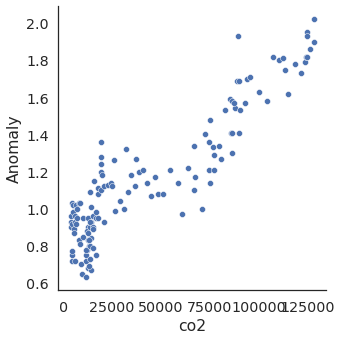

In [ ]:
# Plote um grafico scatter das duas variáveis de interesse.
# Qual intervalo de valores você usaria? Qual subconjunto de pontos do dataset? Por que?
sns.relplot(kind='scatter', data=dfmerge[dfmerge['mes']=='jun'], y='Anomaly', x='co2')

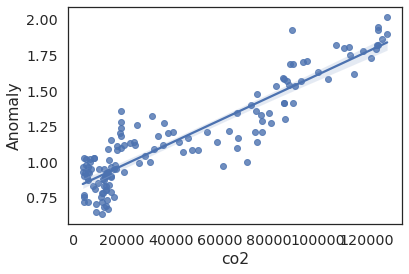

In [ ]:
# Plote a reta da regressão linear usando a função regplot do seaborn
sns.regplot(data=dfmerge[dfmerge['mes']=='jun'], y='Anomaly', x='co2')

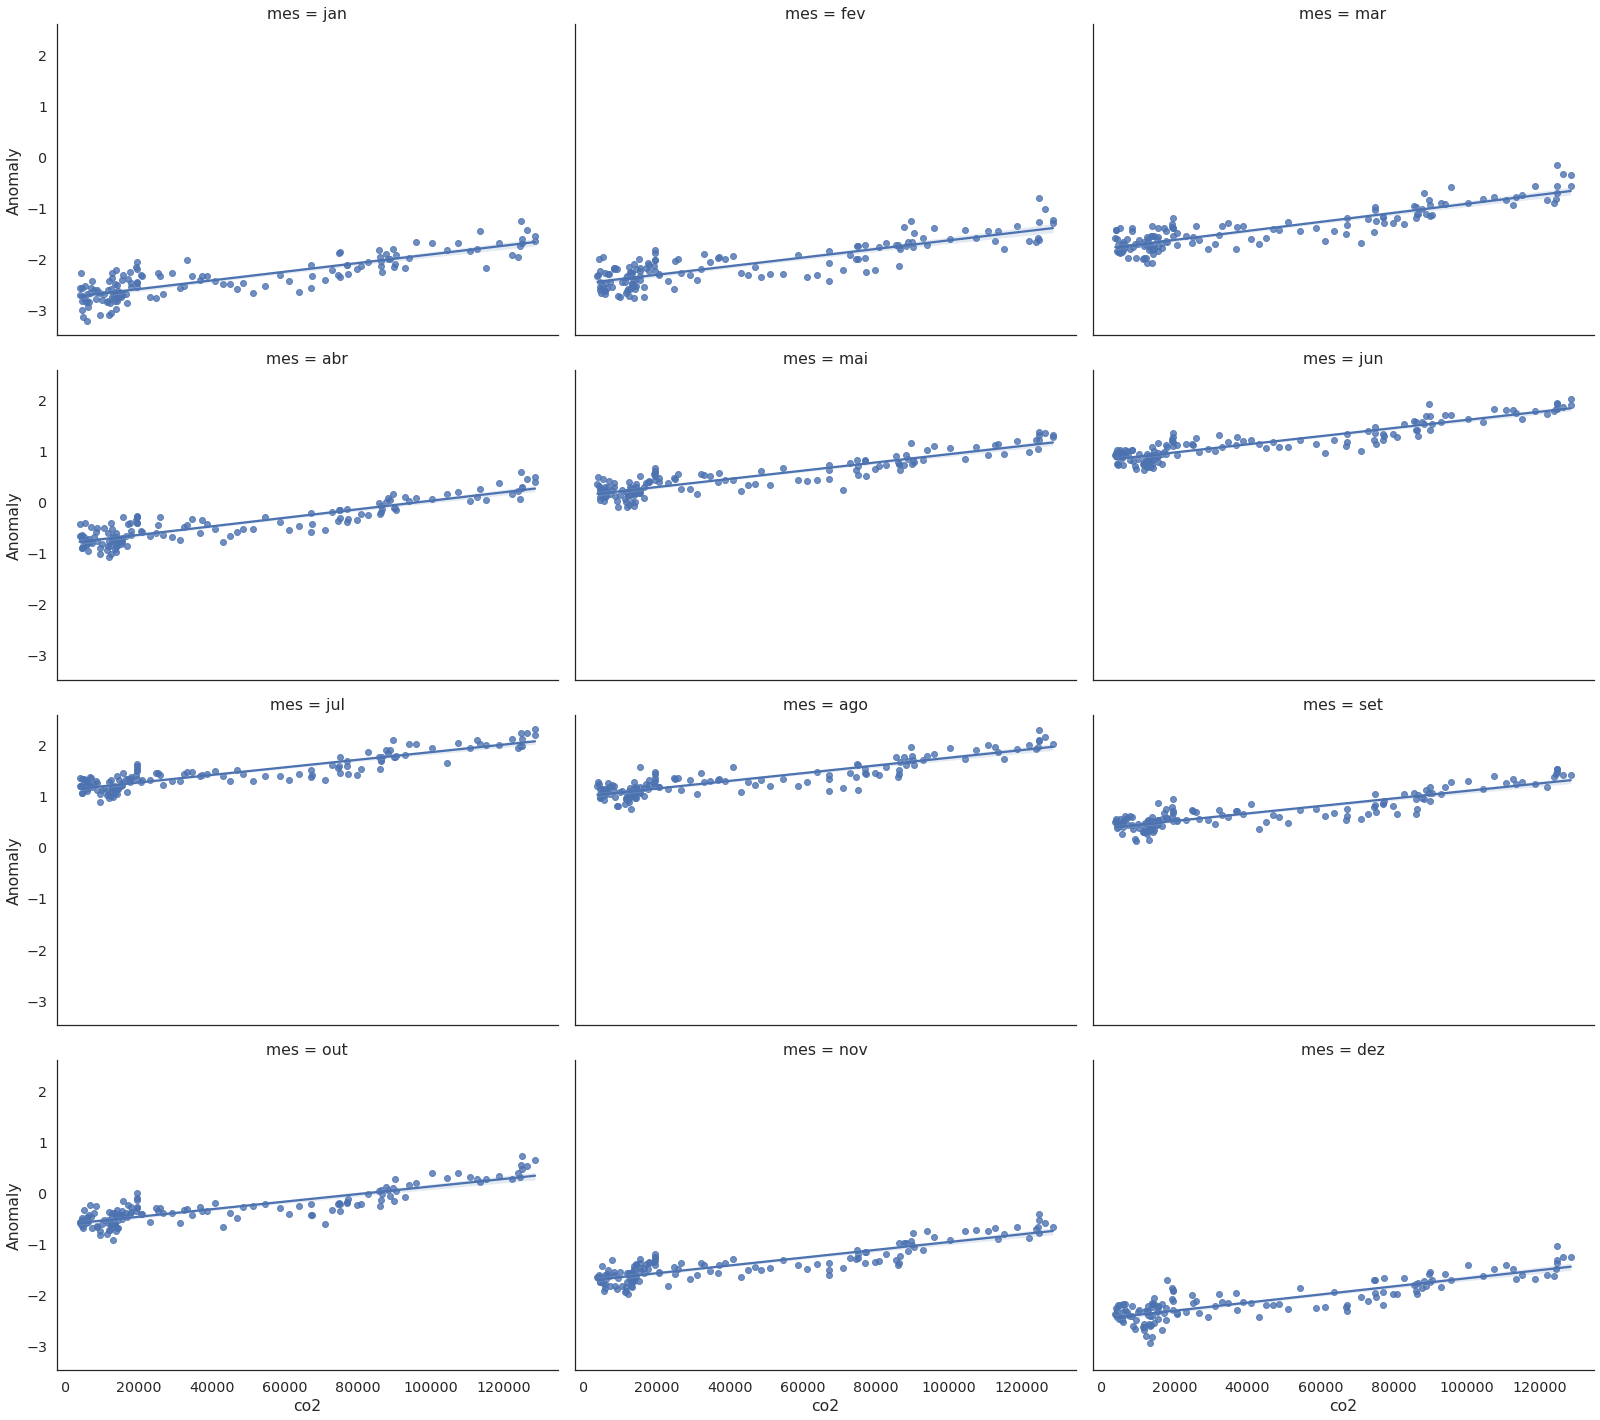

In [ ]:
# Plote um grid de gráficos de regressão linear usando o método lmplot do seaborn. Qual argumento usar para separar as colunas? Qual valor passar nesse argumento?
sns.lmplot(data=dfmerge, y='Anomaly', x='co2', col_wrap=3, col='mes', aspect=1.5)

In [ ]:
# O código abaixo encontra o modelo de regressão linear e retorna o R2 e o P-value de séries de valores agrupadas por mês.
import statsmodels.api as sm
import pandas as pd
import numpy as np

def ols_res(x, y):
    model = sm.OLS(y, x).fit()
    return [model.rsquared, model.f_pvalue]

df.groupby('mes').apply(lambda x : x[['ano']].apply(ols_res, y=x['Anomaly']))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ano
mes                 
jan 0   9.670428e-01
    1  6.828993e-105
fev 0   9.587132e-01
    1   4.340713e-98
mar 0   9.178220e-01
    1   2.651566e-77
abr 0   5.656866e-01
    1   6.002821e-27
mai 0   6.743762e-01
    1   1.115567e-35
jun 0   9.288471e-01
    1   1.182601e-81
jul 0   9.594275e-01
    1   1.290155e-98
ago 0   9.493916e-01
    1   2.714460e-91
set 0   8.324250e-01
    1   2.192080e-55
out 0   4.291679e-01
    1   1.621607e-18
nov 0   9.357522e-01
    1   3.869241e-84
dez 0   9.656224e-01
    1  6.945141e-103

## Atividade Prática em aula
### Repita o gráfico Seasonal Changes presente nesse link http://berkeleyearth.lbl.gov/regions/global-land.

### Não precisa ficar igual, porém, quanto mais você se aproximar, maior será o seu domínio sobre o seaborn e o matplotlib. É uma oportunidade para você treinar sua capacidade de pesquisar uma solução para um problema específico.

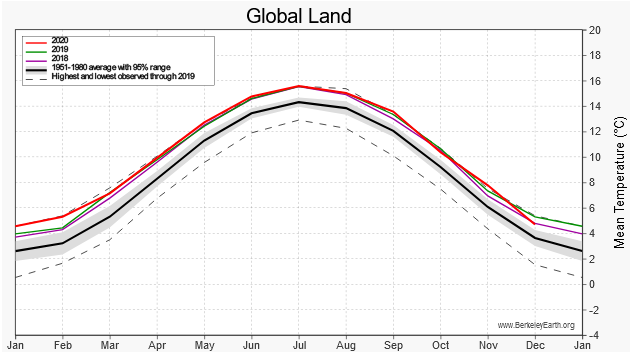

#### Plote as séries de 2016 a 2019 separadamente (não temos as série 2020 no nosso dataset). E uma linha média com seu intervalo de confiança de 95% para os outros anos do dataset.
#### Você vai precisar dos dados de máximo e mínimo para o ano de 2019. Podem ser encontrados [aqui](http://berkeleyearth.lbl.gov/auto/Global/Complete_TMAX_complete.txt) e [aqui](http://berkeleyearth.lbl.gov/auto/Global/Complete_TMIN_complete.txt).

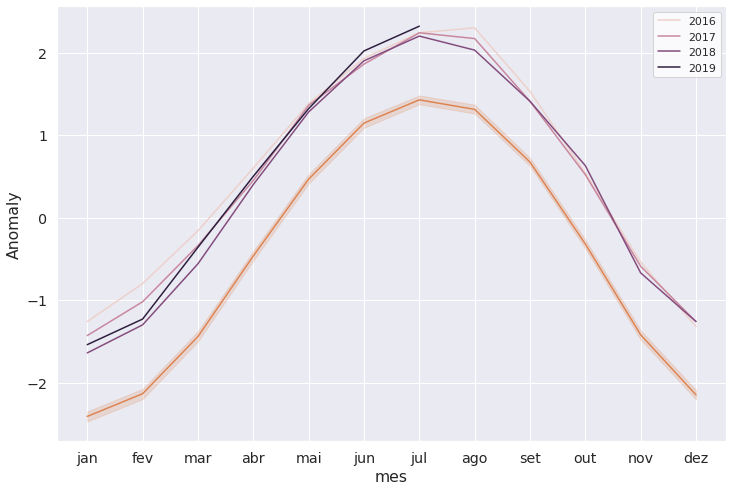

In [ ]:
# Dica você pode plotar várias séries no mesmo gráfico. Comece executando a função subplots do matplotlib
# para criar um objeto figure e um objeto Axes
fig, ax = plt.subplots()

# Se quiser alterar o tamanho do gráfico, utilize a função set_size_inches
fig.set_size_inches(12,8)

# Na sequencia, para cada série/gráfico que quiser plotar, para para uma função de gráfico do seaborn o objeto Axes (ax) como argumento
# Exemplo: Se você fosse plotar um grafico de barras: sns.barplot(data=df,ax=ax, x='mes', y='Anomaly')
sns.set_theme(style="whitegrid")
sns.lineplot(data=df[df['ano'].isin([2019,2018,2017,2016])], ax=ax, hue='ano', x='mes', y='Anomaly')
sns.lineplot(data=df[~df['ano'].isin([2019,2018,2017,2016])], ax=ax, x='mes', y='Anomaly')

In [ ]:
# !pip install pandas-profiling==2.8.0

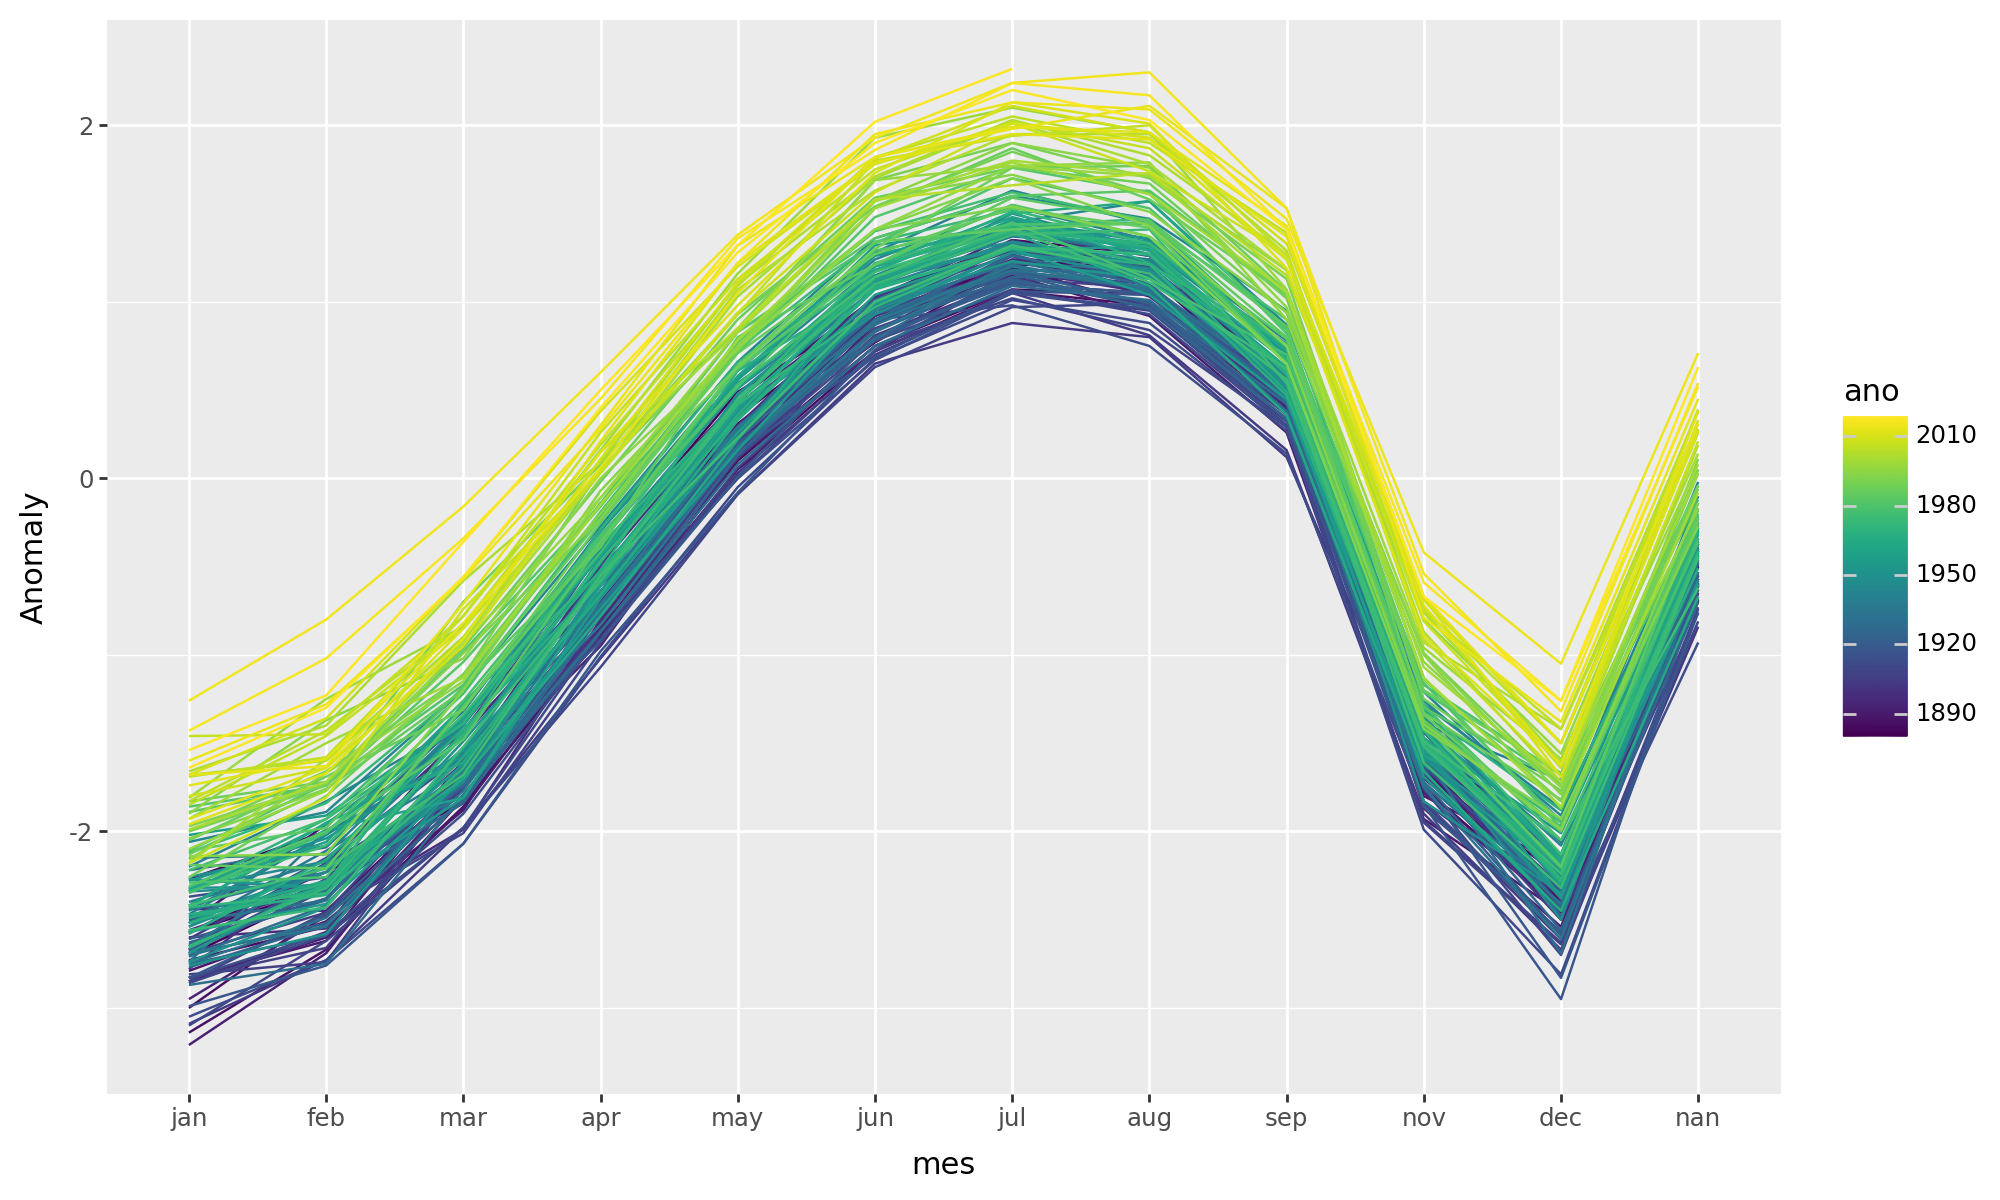

In [49]:
from plotnine import ggplot, aes, geom_line, theme

(ggplot(df, aes(x='mes', y='Anomaly', group='ano', color='ano'))
 + geom_line()
 + theme(figure_size=(10, 6))
)